Unique labels in original data: [0 1 2 3 4 5]
Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.3374 - loss: 1.3252 - val_accuracy: 0.7711 - val_loss: 0.6202
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 0.7958 - loss: 0.4811 - val_accuracy: 0.8930 - val_loss: 0.3008
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9486 - loss: 0.1480 - val_accuracy: 0.9008 - val_loss: 0.3046
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.9641 - loss: 0.1005 - val_accuracy: 0.9094 - val_loss: 0.2668
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.9790 - loss: 0.0608 - val_accuracy: 0.8984 - val_loss: 0.3611
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.9824 - loss: 0.0481 - val_accuracy: 0.9102 - val_loss: 0.3329
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.9885 - loss: 0.0272 - val_accuracy: 0.9078 - val_loss: 0.3493
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 41s 

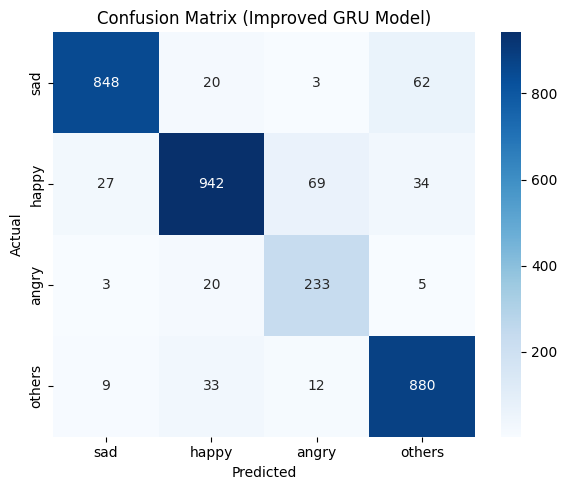

In [1]:
!pip install tensorflow scikit-learn seaborn --quiet

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = "https://raw.githubusercontent.com/UdayPrasadB/NLP_AssignmentCW2/refs/heads/main/train_converted.csv"
df = pd.read_csv(url)

# Prepare inputs
texts = df['text'].astype(str).values
labels = df['label'].values

# --start-- DIAGNOSE AND FIX LABEL RANGE --
# Check for unique values in labels to identify the problematic ones
unique_labels = np.unique(labels)
print("Unique labels in original data:", unique_labels)

# Assuming labels should be in the range [0, 3], let's replace any out-of-range values
# Replace any label value above 3 with 3 (this assumes 'others' category)
labels = np.where(labels > 3, 3, labels)
# --end-- DIAGNOSE AND FIX LABEL RANGE --

tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=50, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, stratify=labels, random_state=42)

# Class weights (Note: recompute after fixing labels)
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(weights))

# Build model (rest of your model code remains the same)

# Build model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    Bidirectional(GRU(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, class_weight=class_weight_dict)

# Predict
y_probs = model.predict(X_test)
y_preds = np.argmax(y_probs, axis=1)

# Evaluate
acc = accuracy_score(y_test, y_preds)
prec = precision_score(y_test, y_preds, average='weighted', zero_division=0)
rec = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

print("\nClassification Report:")
print(classification_report(y_test, y_preds, target_names=["sad", "happy", "angry", "others"], zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["sad", "happy", "angry", "others"], yticklabels=["sad", "happy", "angry", "others"])
plt.title("Confusion Matrix (Improved GRU Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
